# Wiener Filters

TO BE WRITTEN.

This notebook implements the most basic prediction error filter, which is intended to predict observed data $d_i^\text{obs}$ for $i=0, ..., N-1$ using $n$ earlier data $d_{i-j-1}^\text{obs}$ for $j=0, ..., n-1$ via the linear relation (discrete convolution)

\begin{equation}
d_i = \sum_{j=0}^{n-1} d_{i-j-1}^\text{obs} p_j\,.
\end{equation}

The task of finding the $n$ filter coefficients $p_j$ can be formulated as an inverse problem. Assuming that the observational errors are Gaussian with covariance matrix $\mathbf{C}$, the maximum-likelihood set of coefficients minimises the least-squares misfit functional

\begin{equation}
\chi(\mathbf{p}) = \frac{1}{2} \sum_{i,j=0}^{N-1} (d_i - d_i^\text{obs}) C_{ij}^{-1} (d_j - d_j^\text{obs})\,.
\end{equation}

Inserting the forward modelling equation and forcing the derivative of $\chi$ to zero, yields the normal equations

\begin{equation}
\sum_{i,j=0}^{N-1} d_i^\text{obs} C_{ij}^{-1} d_{j-q-1}^\text{obs} = \sum_{k=0}^{n-1} \left( \sum_{i,j=0}^{N-1} d_{i-k-1}^\text{obs} C_{ij}^{-1} d_{j-q-1}^\text{obs} \right)\,p_k\,.
\end{equation}

This can be written in vector-matrix form,

\begin{equation}
b_q = \sum_{k=0}^{n-1} A_{qk} p_k\,,
\end{equation}

with

\begin{equation}
b_q = \sum_{i,j=0}^{N-1} d_i^\text{obs} C_{ij}^{-1} d_{j-q-1}^\text{obs}\,,\qquad A_{qk}=\sum_{i,j=0}^{N-1} d_{i-k-1}^\text{obs} C_{ij}^{-1} d_{j-q-1}^\text{obs}\,.
\end{equation}

From this we see that the left-hand side and the matrix contain auto-correlations of the observations. Hence, linear predictions are made on the basis of the correlation properties of the data.

# 0. Packages and setup

Import the necessary Python packages and add a few lines to embellish figures.

In [1]:
import obspy
import numpy as np
import time as time
import matplotlib.pyplot as plt
from obspy.signal.filter import bandpass

plt.rcParams["font.family"] = "Times"
plt.rcParams.update({'font.size': 50})
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

# 1. Make artificial data

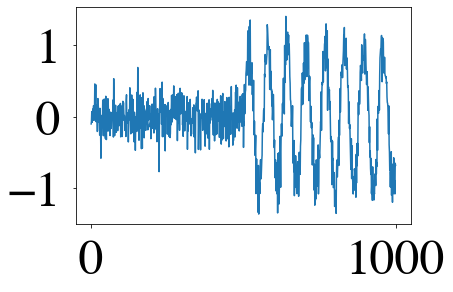

In [2]:
N=1000

d0=np.zeros(N)
t=np.linspace(0.0,100.0,N)
d0[500:N]=np.sin(1.0*t[500:N])
d=d0+0.2*np.random.randn(N)

plt.plot(d)

# 2. Data reading and plotting

## 2.1. Read and plot complete data

## 2.2. Filtering and downsampling

## 2.3. Pick a specific trace

As data, we first pick one of the available traces.

# 3. Noise covariance matrix

We first need an estimate of the data covariance matrix $\mathbf{C}$. For this, we first need to determine the size of the training dataset $N$. We then take a window of this length and slide it across the noise part of the signal, prior to the first wave arrivals. From this, we get average cross-correlations between pairs of samples.

In [3]:
# Number of data points.
Nd=200

# Correlation vector.
corr=np.zeros(Nd)

# Minimum and maximum indices from the noise time series.
imin=100
imax=300

# Compute correlation vector.
for n in np.arange(imin,imax):
    for i in range(Nd):
        corr[i]+=d[n]*d[n+i]

corr/=np.float(imax-imin)

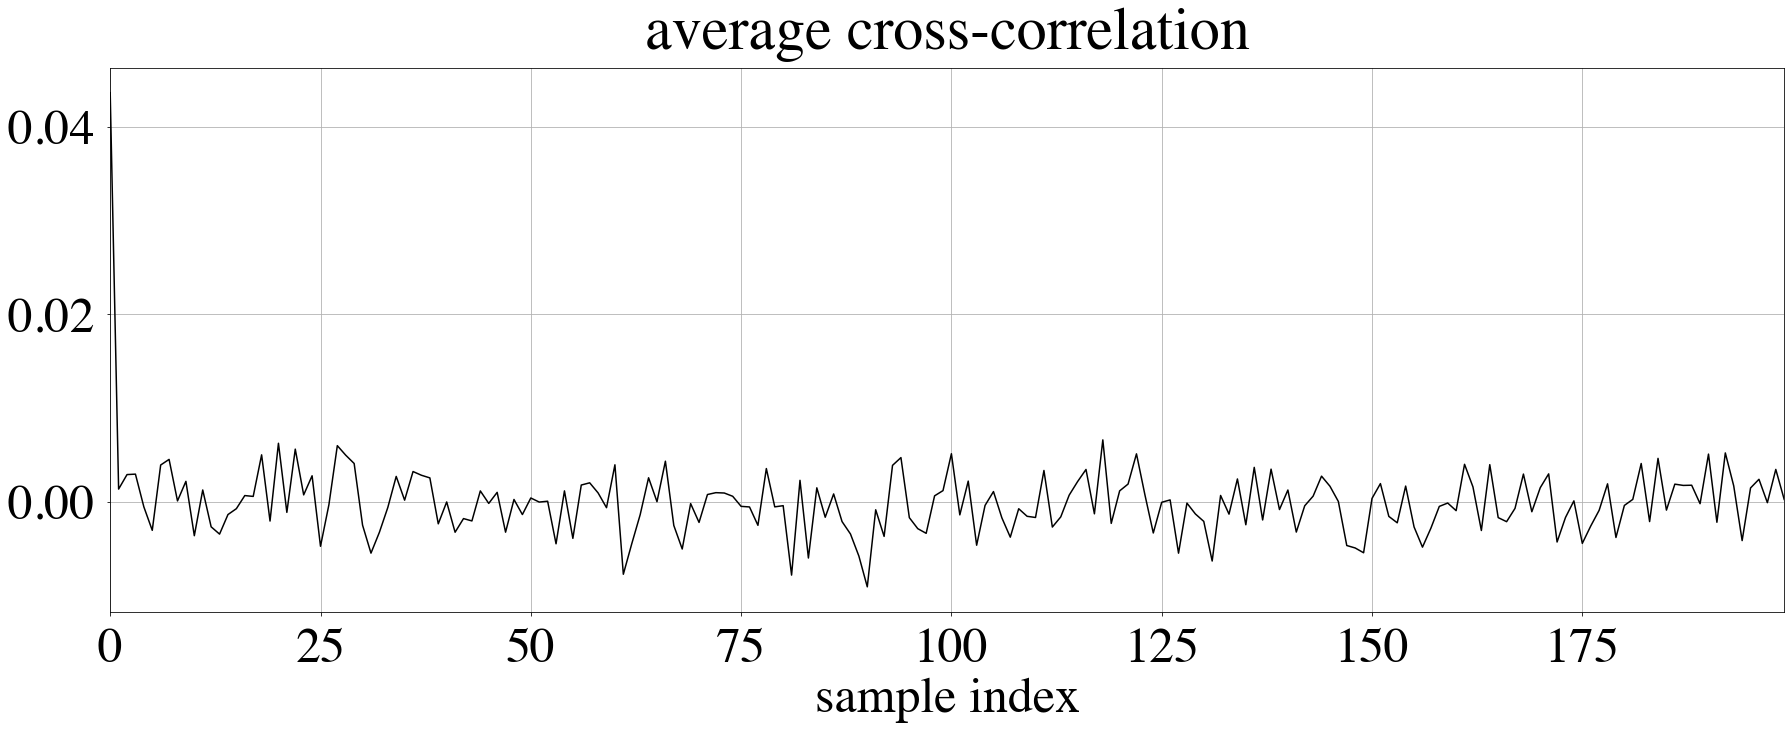

In [4]:
plt.figure(figsize=(30,10))
plt.plot(corr,'k')
plt.grid()
plt.title('average cross-correlation',pad=20)
plt.xlabel('sample index')
plt.xlim([0,Nd-1])
plt.show()

We finally build $\mathbf{C}$ from the average cross-correlation by putting shifted copies of it into the rows of the matrix.

In [5]:
C=np.zeros([Nd,Nd])
for i in range(Nd): C[i,:]=np.roll(corr,i)
Cinv=np.linalg.inv(C)

# 4. Filtering

TO BE WRITTEN.

We start the simple prediction step by choosing a part of the time series that contains actual signal. Based on this, we build the vector $\mathbf{b}$ and the matrix $\mathbf{A}$.

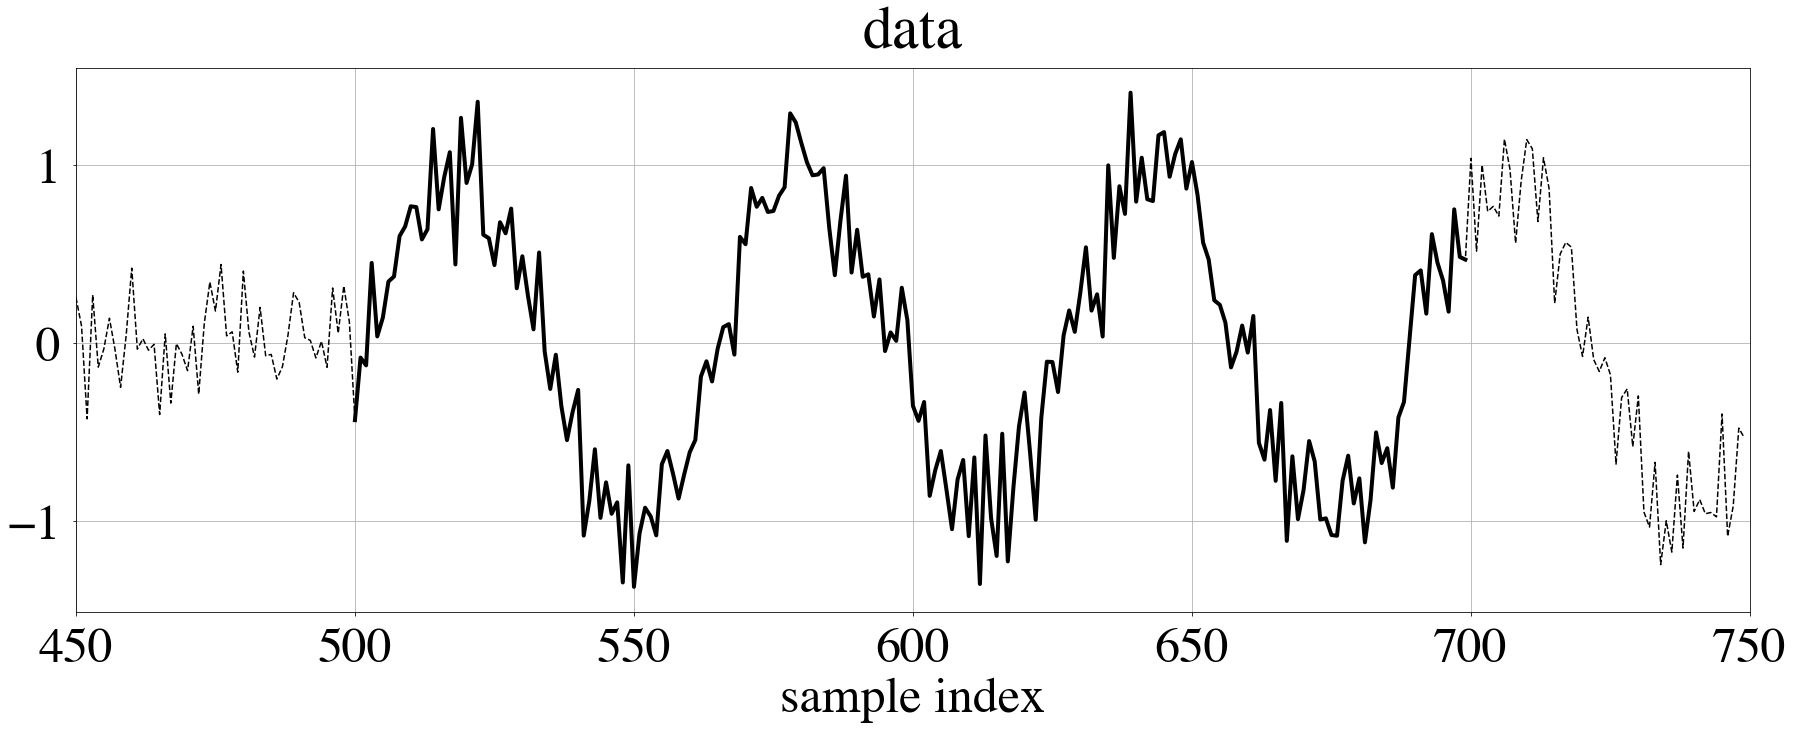

In [6]:
# Starting index of the time series of interest (training dataset).
i0=500

# Plot the training dataset.
plt.figure(figsize=(30,10))
plt.plot(np.arange(i0-50,i0+Nd+50),d[i0-50:i0+Nd+50],'--k')
plt.plot(np.arange(i0,i0+Nd),d[i0:i0+Nd],'k',LineWidth=4)
plt.grid()
plt.xlim([i0-50,i0+Nd+50])
plt.title('data',pad=20)
plt.xlabel('sample index')
plt.show()

In the next step, we assemble $\mathbf{b}$ and $\mathbf{A}$. To make this more efficient, we use the fact that the matrix $X_{i,q}=\sum_{j=0}^{N} C_{ij}^{-1} d_{j-q-1}^\text{obs}$ appears in both $\mathbf{b}$ and $\mathbf{A}$.

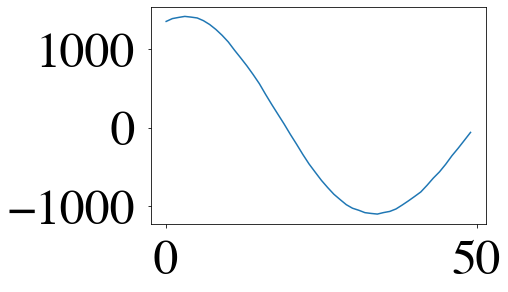

elapsed time: 0.072501 s


In [7]:
# Number of filter coefficients.
n=50

t1=time.time()

# Build the auxiliary matrix X.
X=np.zeros([Nd,n])
for q in range(n): X[:,q]=np.dot(Cinv,d[(i0-q):(i0-q+Nd)])
    
# Build matrix A.
A=np.zeros([n,n])
for k in range(n): A[:,k]=np.dot(d[(i0-k):(i0-k+Nd)],X)

# Compute the exact b.
b=np.dot(d0[i0:(i0+Nd)],X)

plt.plot(b)
plt.show()

t2=time.time()
print('elapsed time: %f s' % (t2-t1))

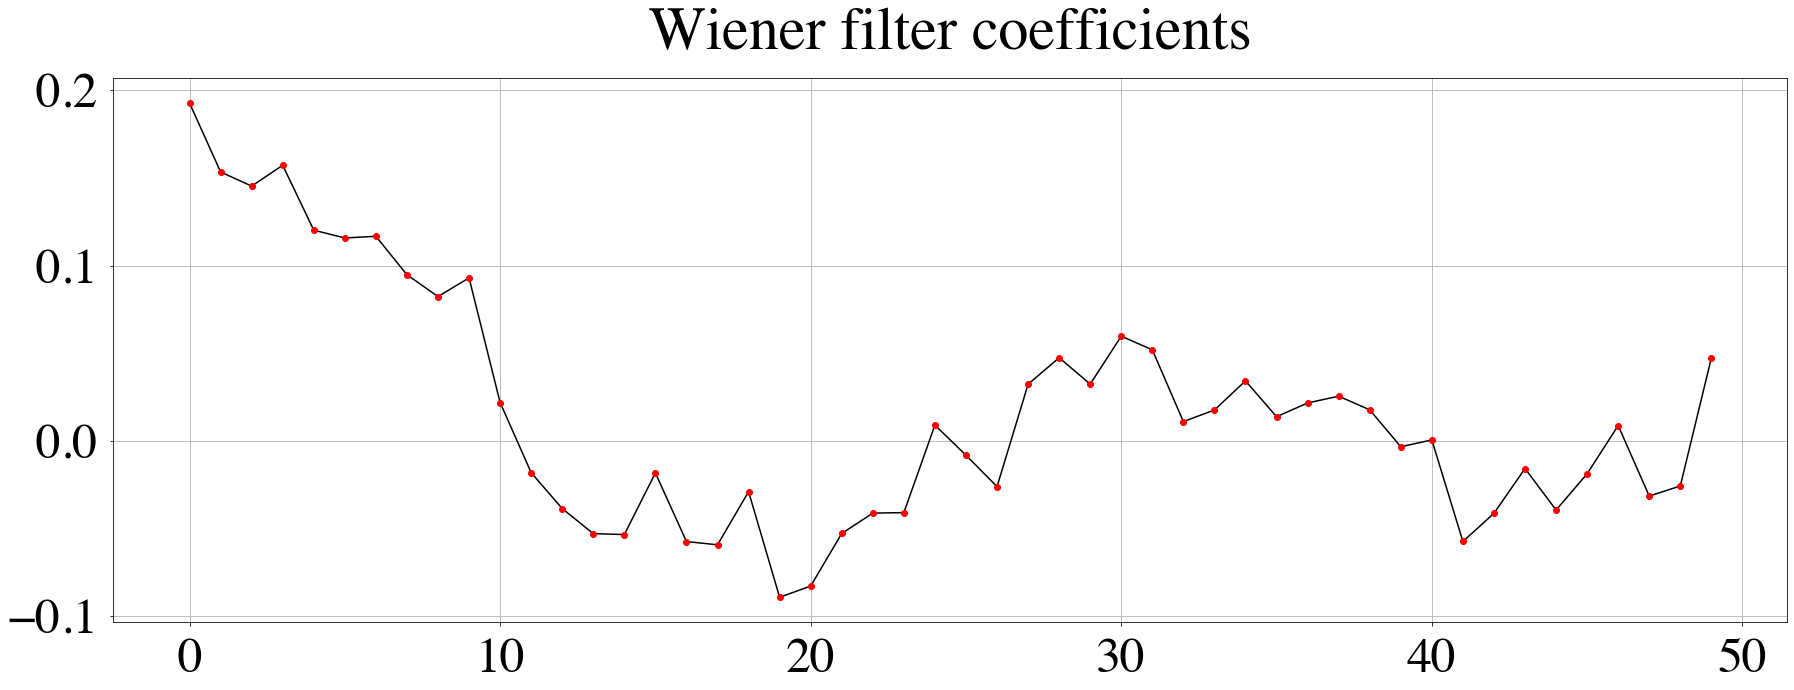

In [8]:
# Solve linear system.
p=np.dot(np.linalg.inv(A),b)

plt.figure(figsize=(30,10))
plt.plot(p,'k')
plt.plot(p,'ro')
plt.grid()
plt.title('Wiener filter coefficients',pad=30)
plt.show()

## 4.1. Filtering the time series dataset

TO BE WRITTEN.

Trying to predict the training dataset helps to check if the algorithm works at all, and it allows us to choose the proper number of model parameters that roughly produces an rms error of 1.

In [9]:
# Compute the prediction.
d_pred=np.zeros(Nd)

for j in range(Nd):
    for i in range(n):
        d_pred[j]+=d[i0+j-i]*p[i]
        
d_pred=d_pred*np.max(np.abs(d[i0:i0+Nd]))/np.max(np.abs(d_pred))

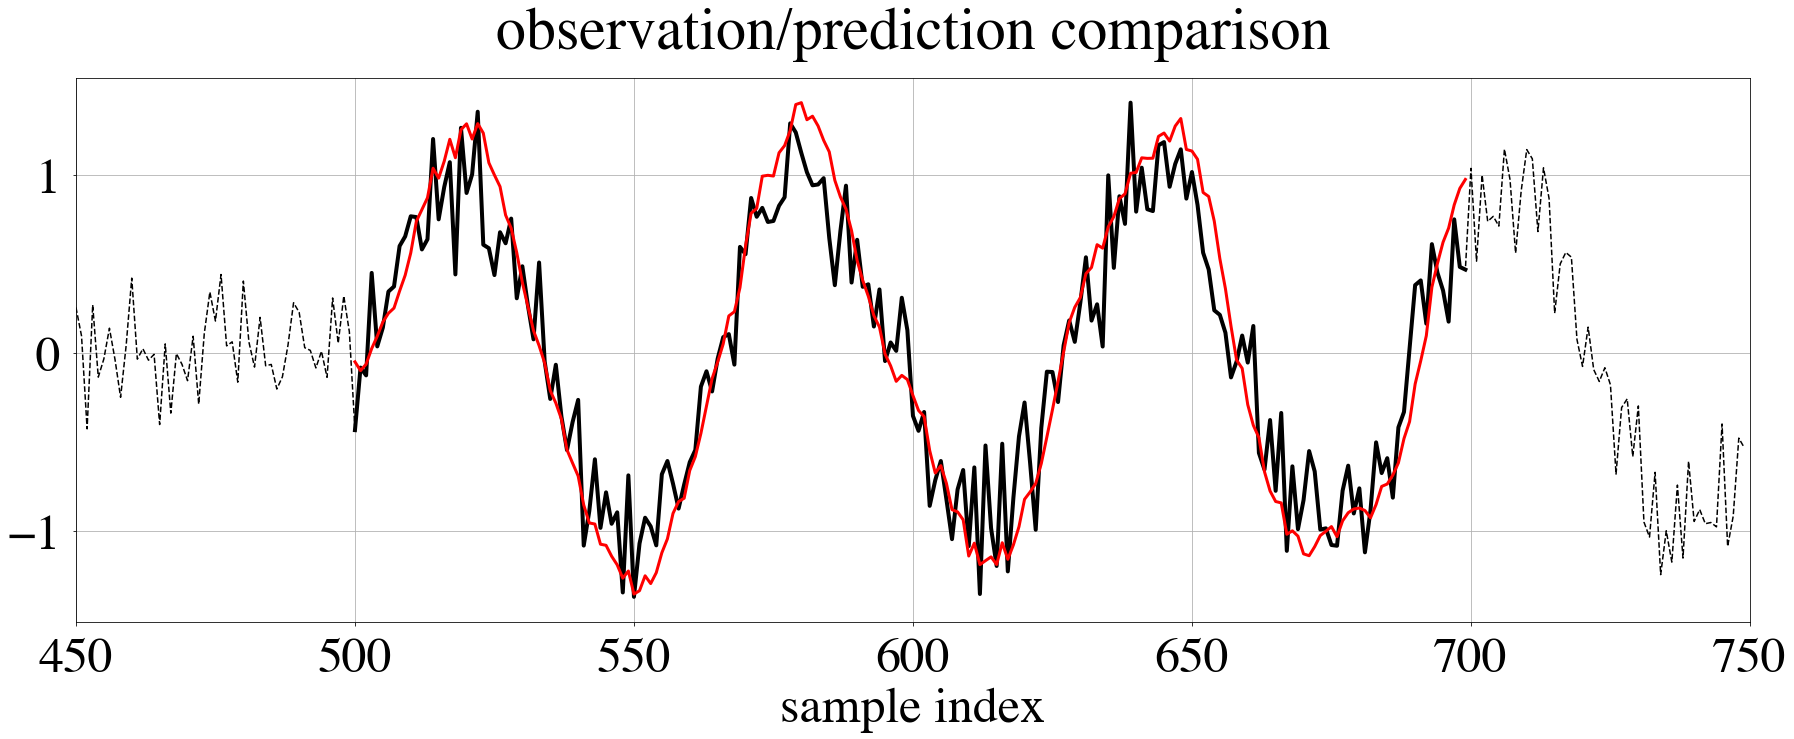

In [10]:
# Plot the comparison of observed and predicted data.
plt.figure(figsize=(30,10))
plt.plot(np.arange(i0-50,i0+Nd+50),d[i0-50:i0+Nd+50],'--k')
plt.plot(np.arange(i0,i0+Nd),d[i0:i0+Nd],'k',LineWidth=4)
plt.plot(np.arange(i0,i0+Nd),d_pred,'r',LineWidth=3)
plt.grid()
plt.xlim([i0-50,i0+Nd+50])
plt.title('observation/prediction comparison',pad=30)
plt.xlabel('sample index')
plt.show()

To check how good the prediction actually is, we compute the rms error using the previously estimated covariance matrix $\mathbf{C}$.

## 4.4. Predicting a different time series

Now we use the same model parameters but for predicting a different time series.

## 5. Repeating this for a part of the record section